In [10]:
# Initial imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)
from torch.utils.data import Subset

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import matplotlib
font = {'size'   : 16}

matplotlib.rc('font', **font)

# Neural network to relate the input spectra to the output physical parameters (temperature and velocity)

### Our goal is fairly simple: train a neural network that matches one spectrum to one set of "nodes" (recall the previous notebook)

### Validate and test the network

### Apply it to real-life data

Possibilities for the network architecture are endless, and, again, you know most of the architectures better than me. What we will do here, is just show the concept and discuss what happens. Later we can make it more fancy



In [11]:
# This is faily simple fully connected, not-so-deep neural network:

# Discuss in moderate detail what each thing does: 


class dnn(nn.Module):
    
    def __init__(self, inputsize, outputsize):
        super(dnn, self).__init__()
        
        self.linear0 = nn.Linear(inputsize,64)
        
        self.linear1 = nn.Linear(128,64)
        self.linear1a = nn.Linear(64,64)
        self.linear2 = nn.Linear(64,32)
        self.linear2a = nn.Linear(32,32)
        self.linear3 = nn.Linear(32,16)
        self.linear3a = nn.Linear(16,16)
        self.linear4 = nn.Linear(16,outputsize)
        
        
        self.activationLR = nn.LeakyReLU()
        self.activationS = nn.Sigmoid()
        
        
        self.dropout05 = nn.Dropout(0.5)
        
        
    def forward(self, data_in):
        
        x = self.linear0(data_in)
        x = self.activationLR(x)
        
        
        #x = self.linear1(x)
        #x = self.activationS(x)
        
        
        x = self.linear2(x)
        x = self.activationLR(x)
        
        
        x = self.linear3(x)
        x = self.activationLR(x)
        
        x = self.linear4(x)
        
        return x
    


In [12]:
def make_model(cudaoption, inputsize, outputsize):
    
    model = dnn(inputsize, outputsize)
    
    if (cudaoption):
        print('[INFO] Cuda model:',torch.cuda.get_device_name(0))
        model = model.to(device)
        
        print('[INFO] Parameters in GPU:',next(model.parameters()).is_cuda) 
        
    return model   

def model_predict(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.forward(inputdata)
    
    output = output.to("cpu")
    return output

## Let's make a function to train:

def compilefit(model, data_in, data_out, data_val_in, data_val_out, nepochs, criterion, cudaoption, lri, output_interval, batch, weight_decayi):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lri, weight_decay = weight_decayi)
    loss_fn = nn.MSELoss()
    loss_val_fn = nn.MSELoss()
    
    if cudaoption:
        data_in = data_in.to(device)
        data_out = data_out.to(device)
        data_val_in = data_val_in.to(device)
        data_val_out = data_val_out.to(device)
        
        
    performance = np.zeros([2,nepochs])
                
    for i in range(0,nepochs):
            
        optimizer.zero_grad()
        
        out = model.forward(data_in)
        loss = loss_fn(data_out, out)
        
        loss.backward()
        optimizer.step()
        
        performance[0,i] = loss.item()
        
        # Validation:
        out_val = model.forward(data_val_in)
        loss_val = loss_val_fn(out_val, data_val_out)
        
        performance[1,i] = loss_val.item()
        
            
        if (i+1)%int(output_interval)==0: print(f' It : {i+1:3d} - residual std : {np.sqrt(loss.item()):.6f} - val std : {np.sqrt(loss_val.item()):.6f}')
    return performance

In [13]:
# test for GPU:

cudaoption = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaoption else "cpu")
print('[INFO] Cuda:', cudaoption)
print('[INFO] Cuda device:', device)

[INFO] Cuda: False
[INFO] Cuda device: cpu


In [40]:
dnn_model = make_model(cudaoption, 400, 3)

In [41]:
from astropy.io import fits

In [42]:
# Load the input data:

data_in = fits.open("normalized_data_in.fits")[0].data
data_in.shape

(250, 477, 4, 100)

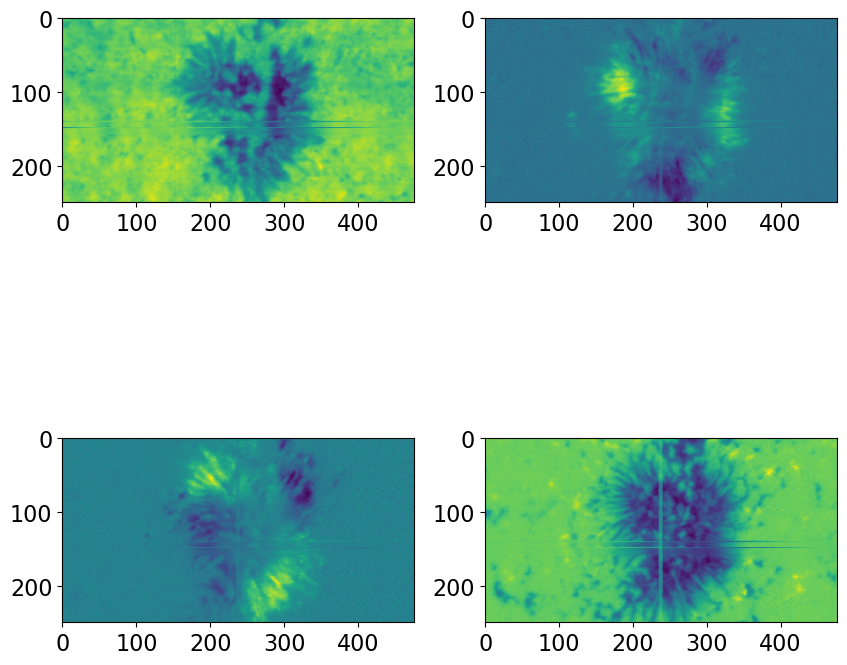

In [43]:
plt.figure(figsize=[10,10])
plt.subplot(221)
plt.imshow(data_in[:,:,0,50])
plt.subplot(222)
plt.imshow(data_in[:,:,1,50])
plt.subplot(223)
plt.imshow(data_in[:,:,2,50])
plt.subplot(224)
plt.imshow(data_in[:,:,3,50])

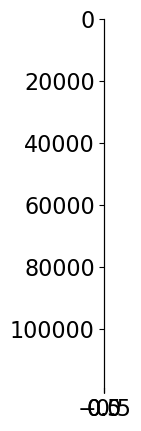

In [44]:
plt.imshow(B_out[:,::-1])

In [45]:
data_in = data_in.reshape(250*477,4*100)

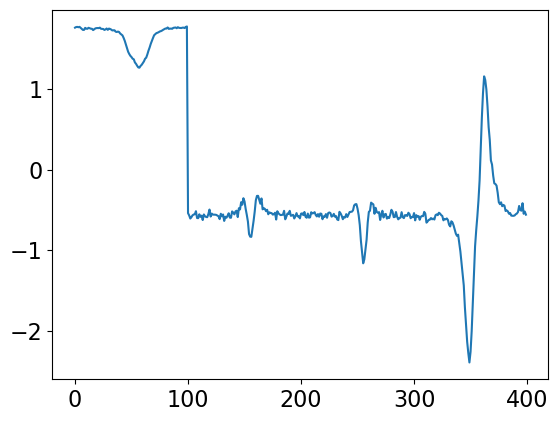

In [46]:
plt.plot(data_in[3125])

In [47]:
# We can now see what our network produces (it's still untrained)

In [48]:
data_in = torch.from_numpy(data_in.astype('float32'))


In [49]:
data_in.shape

torch.Size([119250, 400])

torch.Size([10, 3])


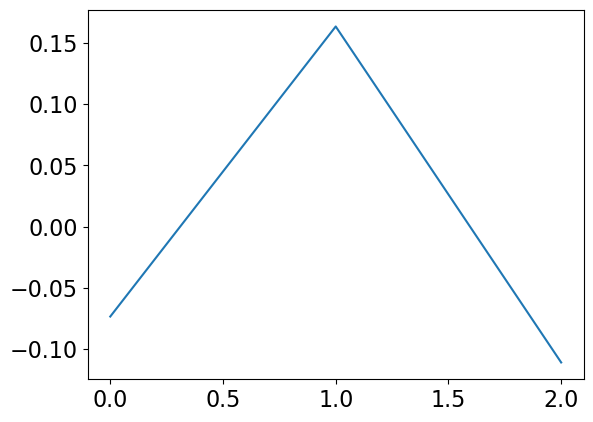

In [50]:
test_output = model_predict(dnn_model,data_in[:10],cudaoption)
print(test_output.shape)
plt.plot(test_output[0].detach().numpy())

### It's something totally random, which should not surprise us as our network is untrained.

### However even if it was, our output is transformed so we would not know if it's correct, we would have to perform some testing. 

In [51]:
# Let's load the output data:
v_out = fits.open("normalized_data_out.fits")[0].data.transpose(1,0)[:,::-1]
B_out = fits.open("normalized_data_out.fits")[1].data.transpose(1,0)[:,::-1]
mu_out = fits.open("normalized_data_out.fits")[2].data.transpose(1,0)[:,::-1]
cos2p_out = fits.open("normalized_data_out.fits")[3].data.transpose(1,0)[:,::-1]
sin2p_out = fits.open("normalized_data_out.fits")[4].data.transpose(1,0)[:,::-1]

In [52]:
v_out.shape

(250, 477)

In [53]:
v_out = v_out.reshape(250*477,1)
B_out = B_out.reshape(250*477,1)
mu_out = mu_out.reshape(250*477,1)
cos2p_out = cos2p_out.reshape(250*477,1)
sin2p_out = sin2p_out.reshape(250*477,1)

In [54]:
data_out = np.concatenate([v_out,B_out,mu_out,cos2p_out,sin2p_out],axis=1)
print (data_out.shape)
data_out = torch.from_numpy(data_out.astype("float32"))

(119250, 5)


In [55]:
# If you want to use already pre-trained model, do:

#dnn_model = torch.load("inv_full_take_1.pt",map_location=torch.device('cpu'))

In [56]:
# We can now try training: 
# Discuss a bit each of the input values to this function:

convergence = compilefit(dnn_model, data_in[:80000,:], data_out[:80000,:3], data_in[80000:,:], data_out[80000:,:3], \
                         1000, 0, cudaoption, 2E-3, 100, 128, 0)

 It : 100 - residual std : 0.542470 - val std : 0.723465
 It : 200 - residual std : 0.464303 - val std : 0.613216
 It : 300 - residual std : 0.383746 - val std : 0.613647
 It : 400 - residual std : 0.340231 - val std : 0.626689
 It : 500 - residual std : 0.309018 - val std : 0.558274
 It : 600 - residual std : 0.287489 - val std : 0.559364
 It : 700 - residual std : 0.277052 - val std : 0.544196
 It : 800 - residual std : 0.266792 - val std : 0.549189
 It : 900 - residual std : 0.258591 - val std : 0.529148
 It : 1000 - residual std : 0.253367 - val std : 0.529605


In [ ]:
torch.save(dnn_model, 'inv_full_take_petnica.pt')

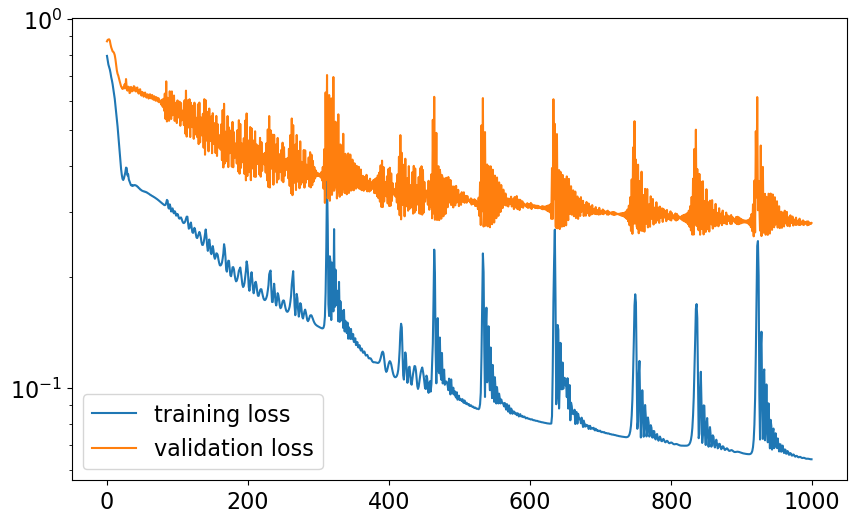

In [57]:
plt.figure(figsize=[10,6])
plt.semilogy(convergence[0],label='training loss') 
plt.semilogy(convergence[1], label = 'validation loss') 
plt.legend()

### Easiest way to test this is to simply apply it to the whole data set and see what comes out :-)

In [58]:
test_output = model_predict(dnn_model,data_in,cudaoption)

In [59]:
test_output = test_output.detach().numpy()

In [60]:
test_output.shape

(119250, 3)

In [62]:
test_output_n = test_output.reshape(250,477,3)
data_out_n = data_out.detach().numpy().reshape(250,477,5)

### How do we do this? 

- We will plot the maps of the original and inferred parameters side by side, as well as scatter plots between the two.

- We will calculate the correlation and the mean difference (stay, std deviation of the difference) between the parameters and compare 

- Note that this is in the "normalized" form, when we transform back it will likely be different

In [38]:
from scipy.stats import pearsonr

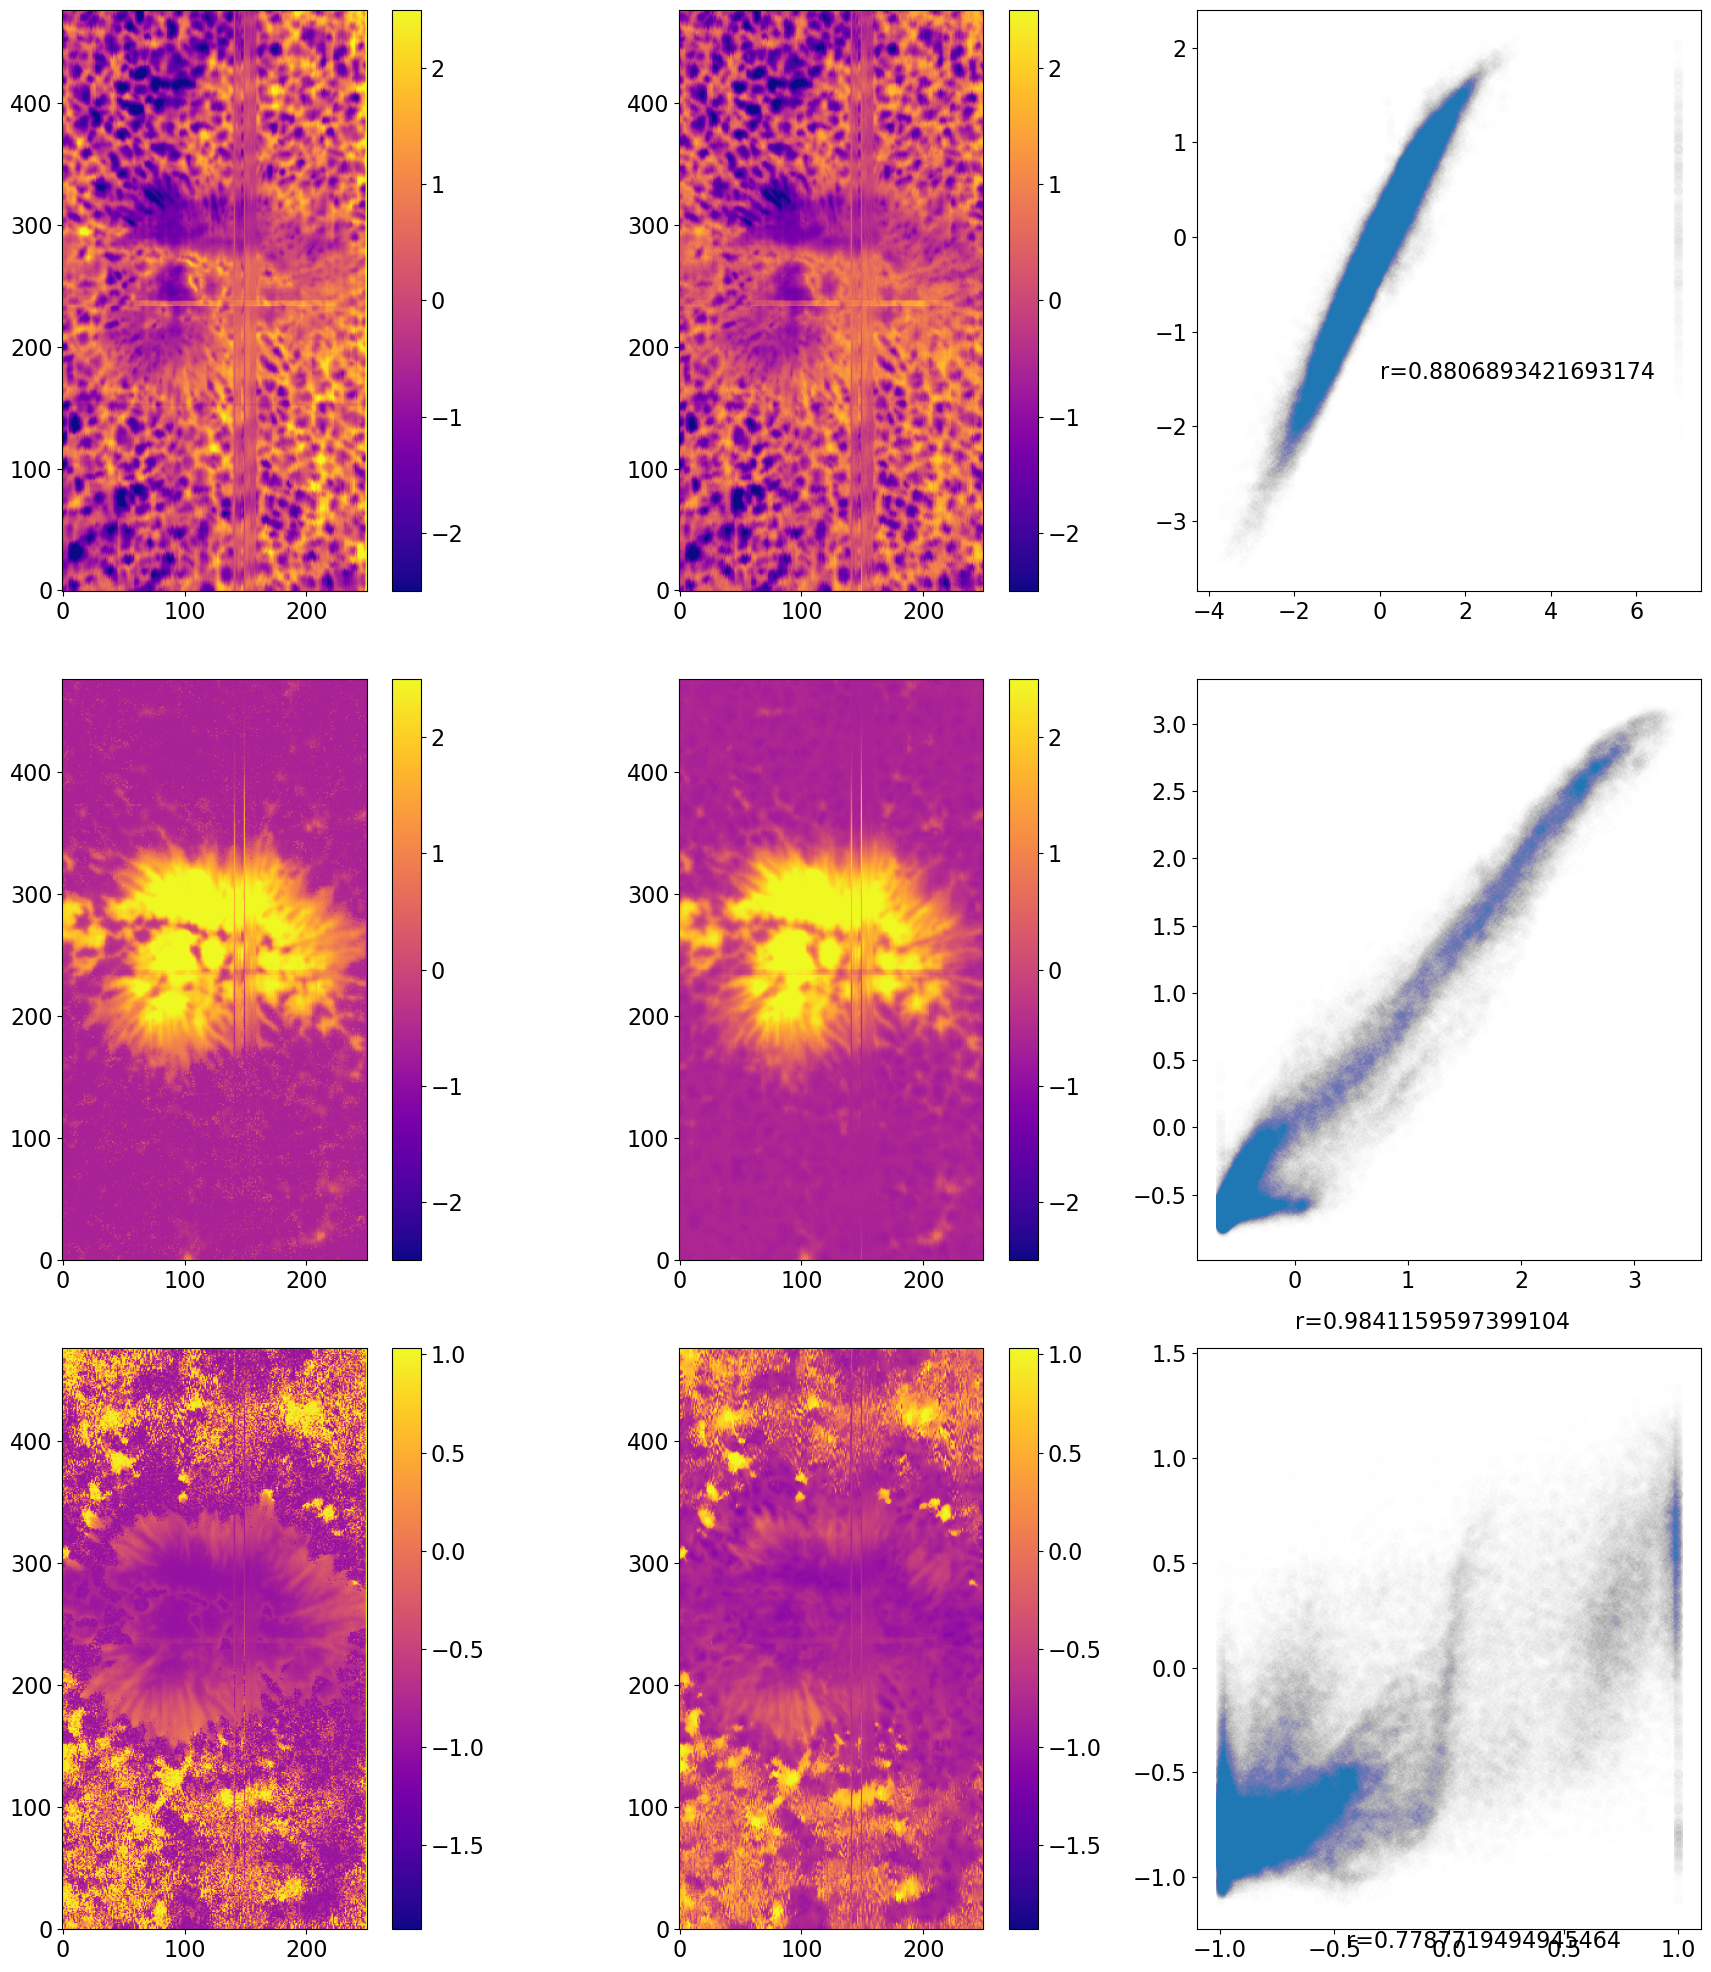

In [63]:
plt.figure(figsize=[18,20])

# First the temperature
NP = 3
for i in range(0,NP):

    m = np.mean(data_out_n[:,:,i])
    s = np.std(data_out_n[:,:,i])
    
    r = pearsonr(data_out_n[:,:,i].flatten(), test_output_n[:,:,i].flatten())
    
    plt.subplot(NP,3,3*i+1)
    plt.imshow(data_out_n[:,:,i].T, origin='lower', cmap='plasma',vmin=m-2.5*s,vmax=m+2.5*s)
    plt.colorbar()
    plt.subplot(NP,3,3*i+2)
    plt.imshow(test_output_n[:,:,i].T, origin='lower', cmap='plasma',vmin=m-2.5*s,vmax=m+2.5*s)
    plt.colorbar()
    plt.subplot(NP,3,3*i+3)
    plt.plot(data_out_n[:,:,i].flatten(),test_output_n[:,:,i].flatten(),'o',alpha=0.002)
    plt.text(m,m-1.5*s,'r='+str(r[0]))
    
plt.tight_layout()



### Can you think of the reasons why the correlation is worse in the upper layers than in the lower ones? What could be happening? 

#### Discuss for a while, go back to the slides if needed

## Same for the velocity:

In [ ]:
plt.figure(figsize=[18,20])

# First the temperature
for i in range(4,8):

    m = np.mean(data_out[:,:,i])
    s = np.std(data_out[:,:,i])
    
    r = pearsonr(data_out[:,:,i].flatten(), test_output[:,:,i].flatten())
    plt.subplot(4,3,3*(i-4)+1)
    plt.imshow(data_out[:,:,i].T, origin='lower', cmap='bwr',vmin=m-2.5*s,vmax=m+2.5*s)
    plt.colorbar()
    plt.subplot(4,3,3*(i-4)+2)
    plt.imshow(test_output[:,:,i].T, origin='lower', cmap='bwr',vmin=m-2.5*s,vmax=m+2.5*s)
    plt.colorbar()
    plt.subplot(4,3,3*(i-4)+3)
    plt.plot(data_out[:,:,i].flatten(),test_output[:,:,i].flatten(),'o',alpha=0.002)
    plt.text(m,m-1.5*s,'r='+str(r[0]))

### Now discuss this one for a little while... 

#### 15 mins to discuss what can be done better, what is going on here, etc. 

#### Maybe talk about the response functions and the ways how we can 'mimic' them via the network? 